# Overview Materi

Jelaskan secara singkat perbedaan antara bagging dan boosting menurut pemahamanmu!
- Bagging (Bootstrap Aggregating) adalah teknik yang membangun beberapa model secara paralel menggunakan sampel data yang diambil secara acak dengan pengembalian (bootstrap). Setiap model belajar secara independen, lalu hasilnya digabung (biasanya dengan voting mayoritas). Tujuannya adalah mengurangi variansi dan mencegah overfitting.

- Boosting, sebaliknya, membangun model secara berurutan (serial). Model baru berfokus pada data yang salah diprediksi oleh model sebelumnya, sehingga kesalahan makin lama makin kecil. Tujuannya adalah mengurangi bias dan meningkatkan akurasi.

# Import Data & Libraries

In [22]:
# import semua libraries yang akan dibutuhkan
# Import semua libraries yang akan dibutuhkan
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

In [23]:
# import data dari datasets.load_breast_cancer
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

data = load_breast_cancer()

# subsetting data
X = data.data
y = data.target

# split data dengan rasio 80:20
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [24]:
# ubah data ke dalam bentuk dataframe agar bisa ditampilkan dalam .head()
import pandas as pd
df = pd.DataFrame(X, columns=data.feature_names)
df['target'] = y

df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


# Bagging from Scratch

## Random Forest Classifier - Sklearn

In [25]:
# gunakan RandomForestClassifier dari sklearn
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    random_state=42
)

clf.fit(X_train, y_train)
preds = clf.predict(X_test)
acc = accuracy_score(y_test, preds)
print(f"Akurasi model Random Forest (Bagging): {acc:.4f}")

Akurasi model Random Forest (Bagging): 0.9561


## Random Forest from Scratch
Source: https://www.youtube.com/watch?v=kFwe2ZZU7yw

In [26]:
import numpy as np
from collections import Counter
from sklearn.tree import DecisionTreeClassifier

class RandomForest:
    def __init__(self, n_trees=10, max_depth=10, min_samples_split=2, n_features=None, random_state=None):
        self.n_trees = n_trees
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.n_features = n_features
        self.random_state = random_state
        self.trees = []

        if self.random_state:
            np.random.seed(self.random_state)

    def fit(self, X, y):
        self.trees = []
        for _ in range(self.n_trees):
            # ambil subset fitur secara acak
            n_features = X.shape[1] if self.n_features is None else self.n_features
            feature_idxs = np.random.choice(X.shape[1], n_features, replace=False)

            # ambil sampel bootstrap (sampling dengan pengembalian)
            X_sample, y_sample = self._bootstrap_samples(X, y)

            # buat decision tree baru
            tree = DecisionTreeClassifier(
                max_depth=self.max_depth,
                min_samples_split=self.min_samples_split,
                random_state=self.random_state
            )
            tree.fit(X_sample[:, feature_idxs], y_sample)
            self.trees.append((tree, feature_idxs))

    def _bootstrap_samples(self, X, y):
        """Mengambil sampel acak dengan pengembalian dari data training."""
        n_samples = X.shape[0]
        idxs = np.random.choice(n_samples, n_samples, replace=True)
        return X[idxs], y[idxs]

    def _most_common_label(self, y):
        """Mengambil label yang paling sering muncul (voting mayoritas)."""
        counter = Counter(y)
        return counter.most_common(1)[0][0]

    def predict(self, X):
        """Prediksi dengan voting mayoritas dari semua pohon."""
        tree_preds = np.array([tree.predict(X[:, idxs]) for tree, idxs in self.trees])
        tree_preds = np.swapaxes(tree_preds, 0, 1)
        predictions = [self._most_common_label(pred) for pred in tree_preds]
        return np.array(predictions)

## Predict Using Random Forest

In [27]:
def accuracy(y_true, y_pred):
    correct = np.sum(y_true == y_pred)
    return correct / len(y_true)

clf = RandomForest(n_trees=10, max_depth=5, random_state=42)
clf.fit(X_train, y_train)
predictions = clf.predict(X_test)


# print score menggunakan metrik accuracy
acc = accuracy(y_test, predictions)
print(f"Akurasi model Random Forest (manual): {acc:.4f}")

Akurasi model Random Forest (manual): 0.9561


# Boosting From Scratch

## Gradient Boosting Classifier - Sklearn

In [28]:
# define and train the model using GradientBoostingClassifier from Sklearn
from sklearn.ensemble import GradientBoostingClassifier

clf = GradientBoostingClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    random_state=42
)

clf.fit(X_train, y_train)
preds = clf.predict(X_test)

# print score menggunakan metrik accuracy
acc = accuracy_score(y_test, preds)
print(f"Akurasi model Gradient Boosting: {acc:.4f}")

Akurasi model Gradient Boosting: 0.9561


## Gradient Boosting from Scratch with Decision Tree
Source: https://www.youtube.com/watch?v=Pq2mmJxjs1o

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor

# fungsi aktivasi sigmoid
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

class gradientBoostingClassifier:
    def __init__(self, lr=0.1, n_estimators=25, base_learner=DecisionTreeRegressor):
        self.lr = lr
        self.n_estimators = n_estimators
        self.base_learner = base_learner
        self.base_models = []

    def fit(self, X, y, **params):
        self.base_models = []

        # Inisialisasi model awal (F0)
        Fm = np.zeros_like(y, dtype=float)

        # buat figure untuk visualisasi proses training
        fig, axs = plt.subplots(5, 5, figsize=(10, 10))
        axs = axs.flatten()

        for i in range(self.n_estimators):
            # hitung residual (negative gradient)
            r_i = y - sigmoid(Fm)

            # latih base learner (regressor) pada residual
            h_i = self.base_learner(**params)
            h_i.fit(X, r_i)
            self.base_models.append(h_i)

            # update model Fm
            Fm += self.lr * h_i.predict(X)

            # plotting proses pembelajaran setiap iterasi
            if i < 25:  # hanya plot 25 pertama
                axs[i].scatter(X[:, 0], y, color="blue", s=10, label="True y")
                axs[i].scatter(X[:, 0], sigmoid(Fm), color="red", s=10, label="Predicted")
                axs[i].set_title(f"Iterasi {i+1}")
                axs[i].legend(loc="lower right", fontsize=6)

        plt.tight_layout()
        plt.show()

    def predict(self, X):
        # inisialisasi prediksi awal
        Fm = np.zeros(X.shape[0])
        for h_i in self.base_models:
            Fm += self.lr * h_i.predict(X)

        probs = sigmoid(Fm)
        return (probs >= 0.5).astype(int)

## Predict Using Gradient Boosting

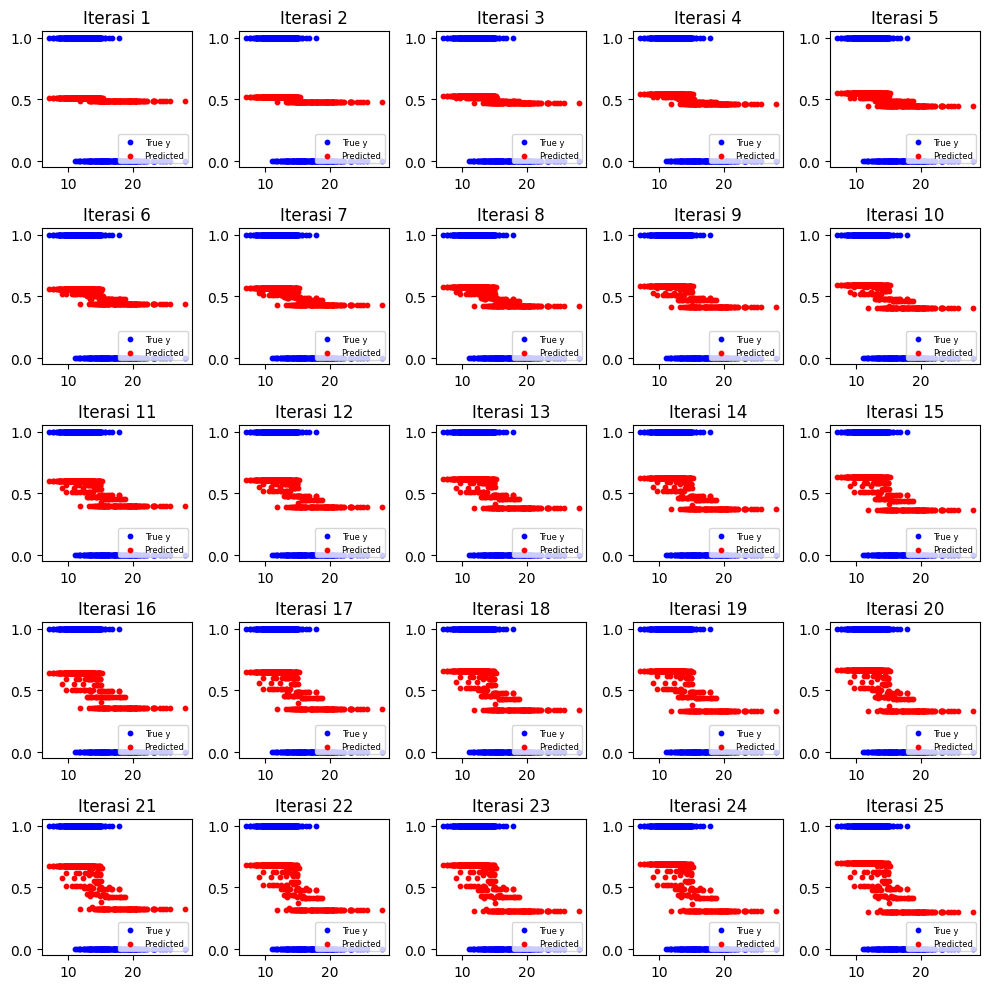

In [30]:
# define and train the model
gb = gradientBoostingClassifier(lr=0.1, n_estimators=25)
gb.fit(X_train, y_train, max_depth=1)

In [31]:
# get predictions:
preds = gb.predict(X_test)

# print score menggunakan metrik accuracy
from sklearn.metrics import accuracy_score
print("Akurasi Gradient Boosting (manual):", accuracy_score(y_test, preds))


Akurasi Gradient Boosting (manual): 0.9473684210526315


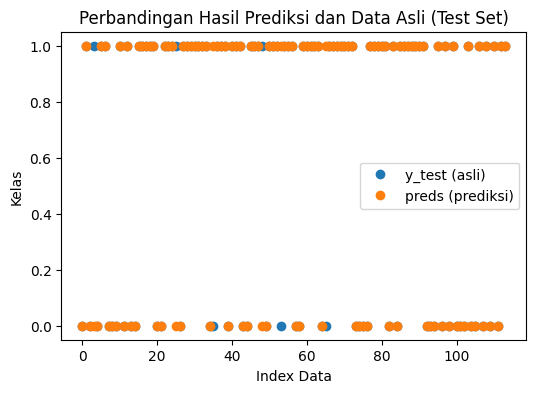

In [32]:
# plot predictions vs. the ground truth:
import matplotlib.pyplot as plt

_, ax = plt.subplots(1, 1, figsize=(6, 4))
plt.title('Perbandingan Hasil Prediksi dan Data Asli (Test Set)')
ax.plot(y_test, 'o', label='y_test (asli)')
ax.plot(preds, 'o', label='preds (prediksi)')
ax.legend()
plt.xlabel('Index Data')
plt.ylabel('Kelas')
plt.show()